# scFoundation Embedding Evaluation – Dataset 1
This interactive notebook evaluates the `X_scFoundation` embedding and **prints** cluster quality metrics instead of saving them to a file.


## Imports & parameters

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, confusion_matrix
from sklearn.decomposition import IncrementalPCA
import pathlib, os
from tqdm.notebook import tqdm

DATA_PATH = pathlib.Path('data/scfoundation_dataset2_with_50neighbors_and_louvan_leiden.h5ad')
OUTPUT_DIR = pathlib.Path('data')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = OUTPUT_DIR

K_NEIGHBORS = 50
COMPONENTS_RANGE = range(2, 16)
RANDOM_STATE = 0
EMBED_KEY = 'X_scFoundation'


## Load dataset

In [ ]:
if not DATA_PATH.is_file():
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")
adata = sc.read_h5ad(DATA_PATH)
print(adata)
print('Embedding present:', EMBED_KEY in adata.obsm_keys())


AnnData object with n_obs × n_vars = 205153 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Stage_Code', 'Tissue', 'Risk_Category', 'First_Avail_TP', 'MYCN_Status', 'ALK_Status', 'TP53_Status', 'Response', 'Vital_Status', 'Age_at_IDX_in_months', 'Treatment', 'First_Avail_Time_Point', 'sample_name', 'biospecimen_id', 'percent.mt', 'seurat_clusters', 'sample_label_wo_prefix', 'S.Score', 'G2M.Score', 'Phase', 'malignancy', 'cell_state', 'RNA_snn_res.0.2', 'MES_Score', 'ADRN_Score', 'MES_ADRN_diff', 'Event', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'tissue_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'leiden', 'louvain'
   

## iPCA

In [5]:
embeddings = adata.obsm[EMBED_KEY].copy()
n_samples, n_features = embeddings.shape
batch_size = 5000
n_components = 50

# Create IncrementalPCA object
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Fit in batches
for batch in tqdm(np.array_split(embeddings, n_samples // batch_size)):
    ipca.partial_fit(batch)

  0%|          | 0/41 [00:00<?, ?it/s]

In [6]:
# Transform the data
reduced_embeddings = ipca.transform(embeddings)
print(reduced_embeddings.shape)

(205153, 50)


In [8]:
iPCA_KEY = 'i_PCA_X_scFoundation'
adata.obsm[iPCA_KEY] = reduced_embeddings

## Build 50‑nearest‑neighbor graph

In [11]:
sc.pp.neighbors(adata, n_neighbors=K_NEIGHBORS, use_rep=iPCA_KEY, random_state=RANDOM_STATE)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
adata.write_h5ad(OUTPUT_DIR / 'scfoundation_dataset2_ipca_with_50_neighbors.h5ad', compression='gzip')

## UMAP graph

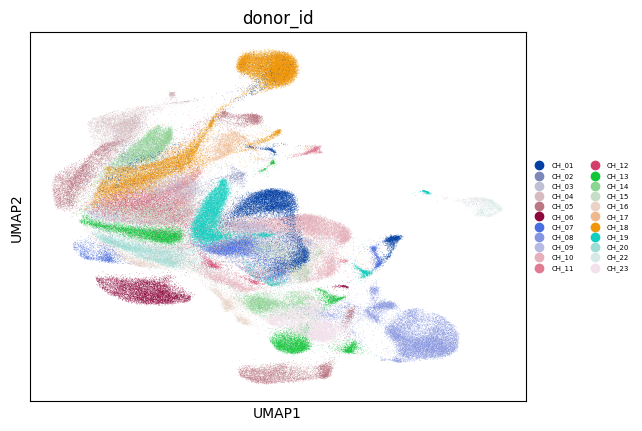

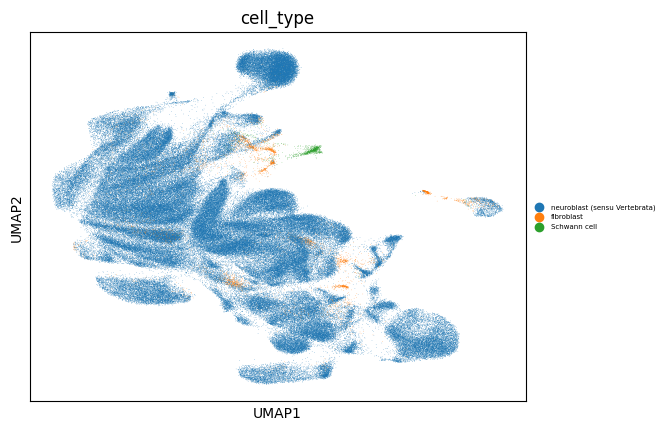

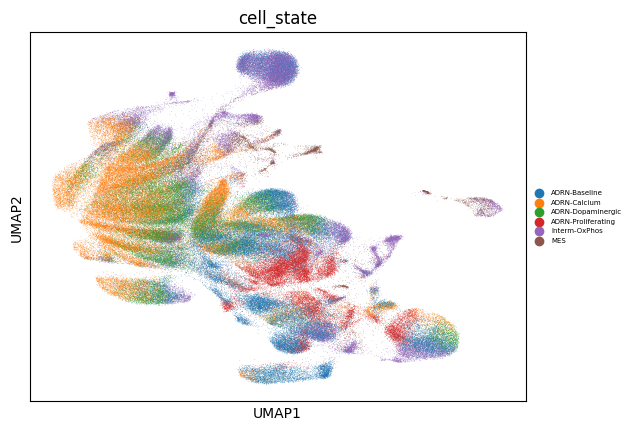

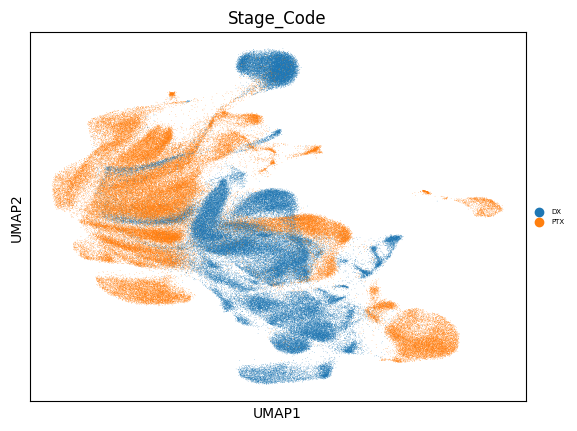

In [4]:
sc.tl.umap(adata)
umap_obs = ['donor_id', 'cell_type', 'cell_state', 'Stage_Code']
for feature in umap_obs:
    sc.pl.umap(adata, color=feature, legend_fontsize=5)